# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Model Selection

In this jupyter notebook, we will try multiple models for prediction and choose the best fitting one.

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, StackingClassifier

from src.preprocessing.helpers import describe_dataset
from src.evaluation import *

In [4]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Load train and test data

The data from previous, preprocessing phase will be used.

In [5]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

Let's check how many data are available and also the distribution of each class in train and test dataset:

In [6]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 81409
Number of test data: 20353
Number of features: 53
Classes:
	0 :
	    train: 72315 samples, 89.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 11.0%
	    test: 2263 samples, 11.0%



### Data balancing

Because data are heavily imbalanced, two techniques for data balancing will be tried - undersampling by random and oversampling with SMOTE method.

#### Undersampling by random

In [7]:
X_train_undersampled, y_train_undersampled = undersample(X_train, y_train)

In [8]:
len(X_train_undersampled), len(y_train_undersampled)

(18188, 18188)

#### Oversampling with SMOTE

In [9]:
X_train_oversampled, y_train_oversampled = oversample(X_train, y_train)

In [10]:
len(X_train_oversampled), len(y_train_oversampled)

(144630, 144630)

### Models training and evaluation

We will evaluate three models:
* Random forest,
* MLP,
* XGBoost.

All models will be trained separately on three data sets:
* original data,
* undersampled data,
* oversampled data.

For complex evaluation of models, multiple metrics like accuracy, precision, recall, f1-score or AUC ROC score will be used. Also, confusion matrix and ROC curve will be plotted to better understand model's predictions. To choose the right model that will be used in final evaluation phase (with feature selection, hyperparameter tuning, etc), we will take into account AUC ROC that is commonly used for binary classification (also previous works with this dataset used AUC ROC as main metric).

Hyperparameters are not tuned here (just manually chosen). Feature selection and hyperparameter tuning will be done in next evaluation phase on algorithm chosen from this phase.

#### Random Forest

##### 1. Original data

              precision    recall  f1-score   support

           0       0.92      0.69      0.79     18090
           1       0.17      0.53      0.26      2263

    accuracy                           0.67     20353
   macro avg       0.55      0.61      0.52     20353
weighted avg       0.84      0.67      0.73     20353

ROC AUC score: 0.651


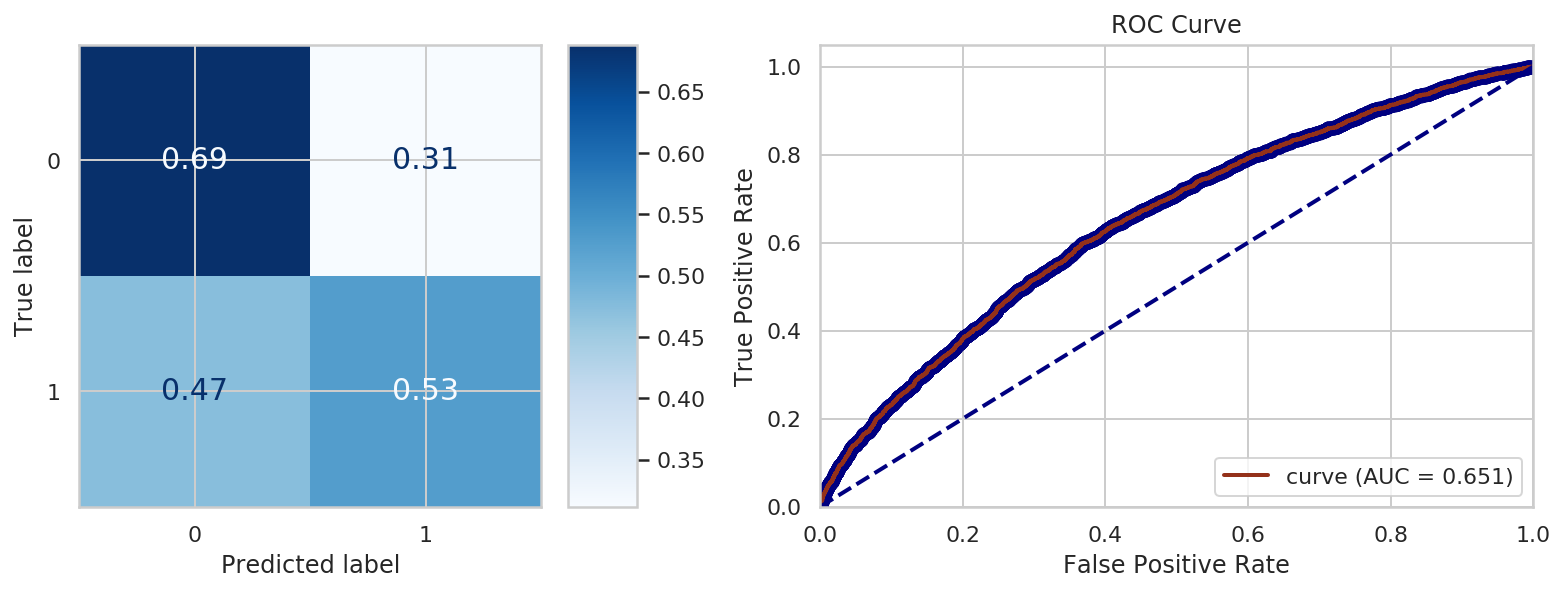

In [11]:
rf = RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.93      0.59      0.72     18090
           1       0.16      0.63      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.54      0.61      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.651


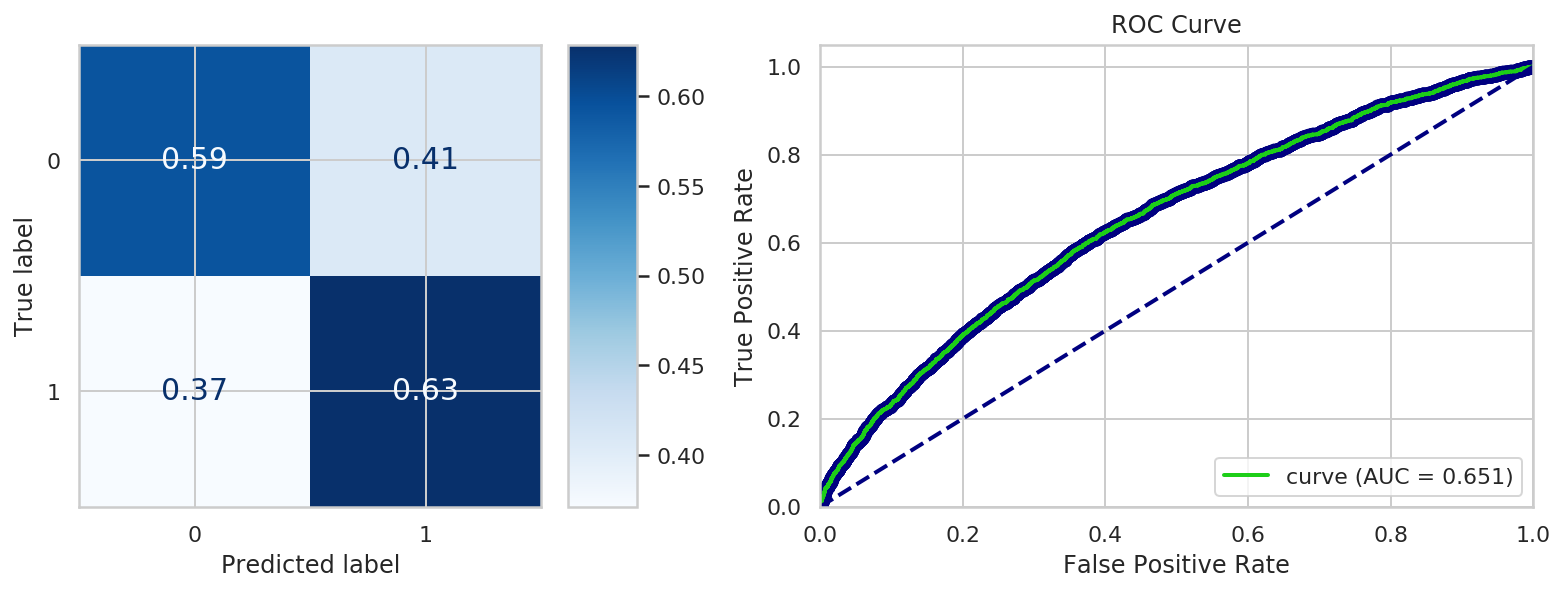

In [12]:
rf_u = RandomForestClassifier(max_depth=10, random_state=42)
rf_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(rf_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.92      0.38      0.53     18090
           1       0.13      0.75      0.22      2263

    accuracy                           0.42     20353
   macro avg       0.53      0.56      0.38     20353
weighted avg       0.84      0.42      0.50     20353

ROC AUC score: 0.599


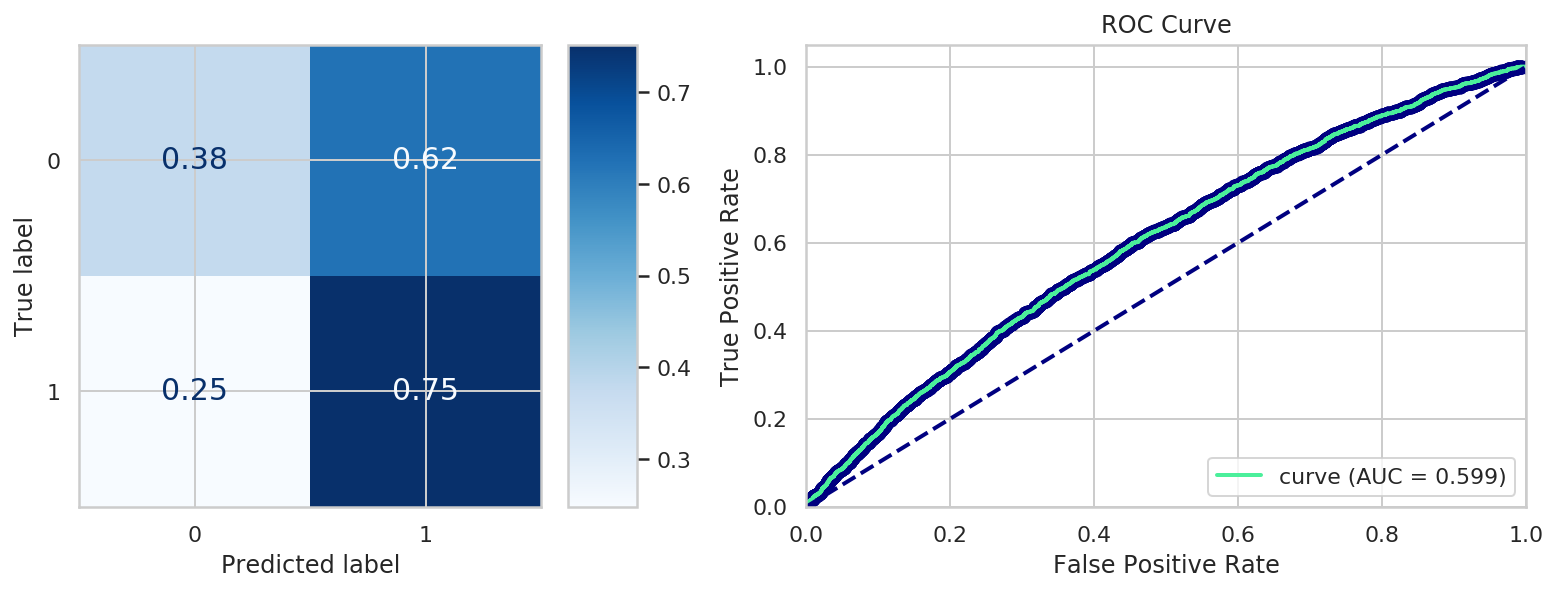

In [13]:
rf_o = RandomForestClassifier(max_depth=10, random_state=42, class_weight={0:1,1:4})
rf_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(rf_o, X_test, y_test)

##### Results comparison

The comparison of Random forest models on original, undersampled and oversampled data can be seen in table below. As we can see, using SMOTE technique for oversampling decreased performance of model. Comparable results have been achieved by Random forest with class weighting and Random forest trained on undersampled data.

In [14]:
compare_models([rf, rf_u, rf_o], 
               ['RF', 'RF undersampled', 'RF oversampled'], 
               X_test, y_test)

                    Accuracy   F1 (micro)  F1 (macro)  Precision   Recall    AUC ROC
RF                |   0.67   |   0.67    |   0.52    |   0.17    |   0.53   |   0.65   |
RF undersampled   |   0.60   |   0.60    |   0.49    |   0.16    |   0.63   |   0.65   |
RF oversampled    |   0.42   |   0.42    |   0.38    |   0.13    |   0.75   |   0.60   |


##### Feature importances 

Let's take a look on the most important features obtained by RF on original data.

We can see that most useful features correspond with those mentioned in similar works from publicated papers. 

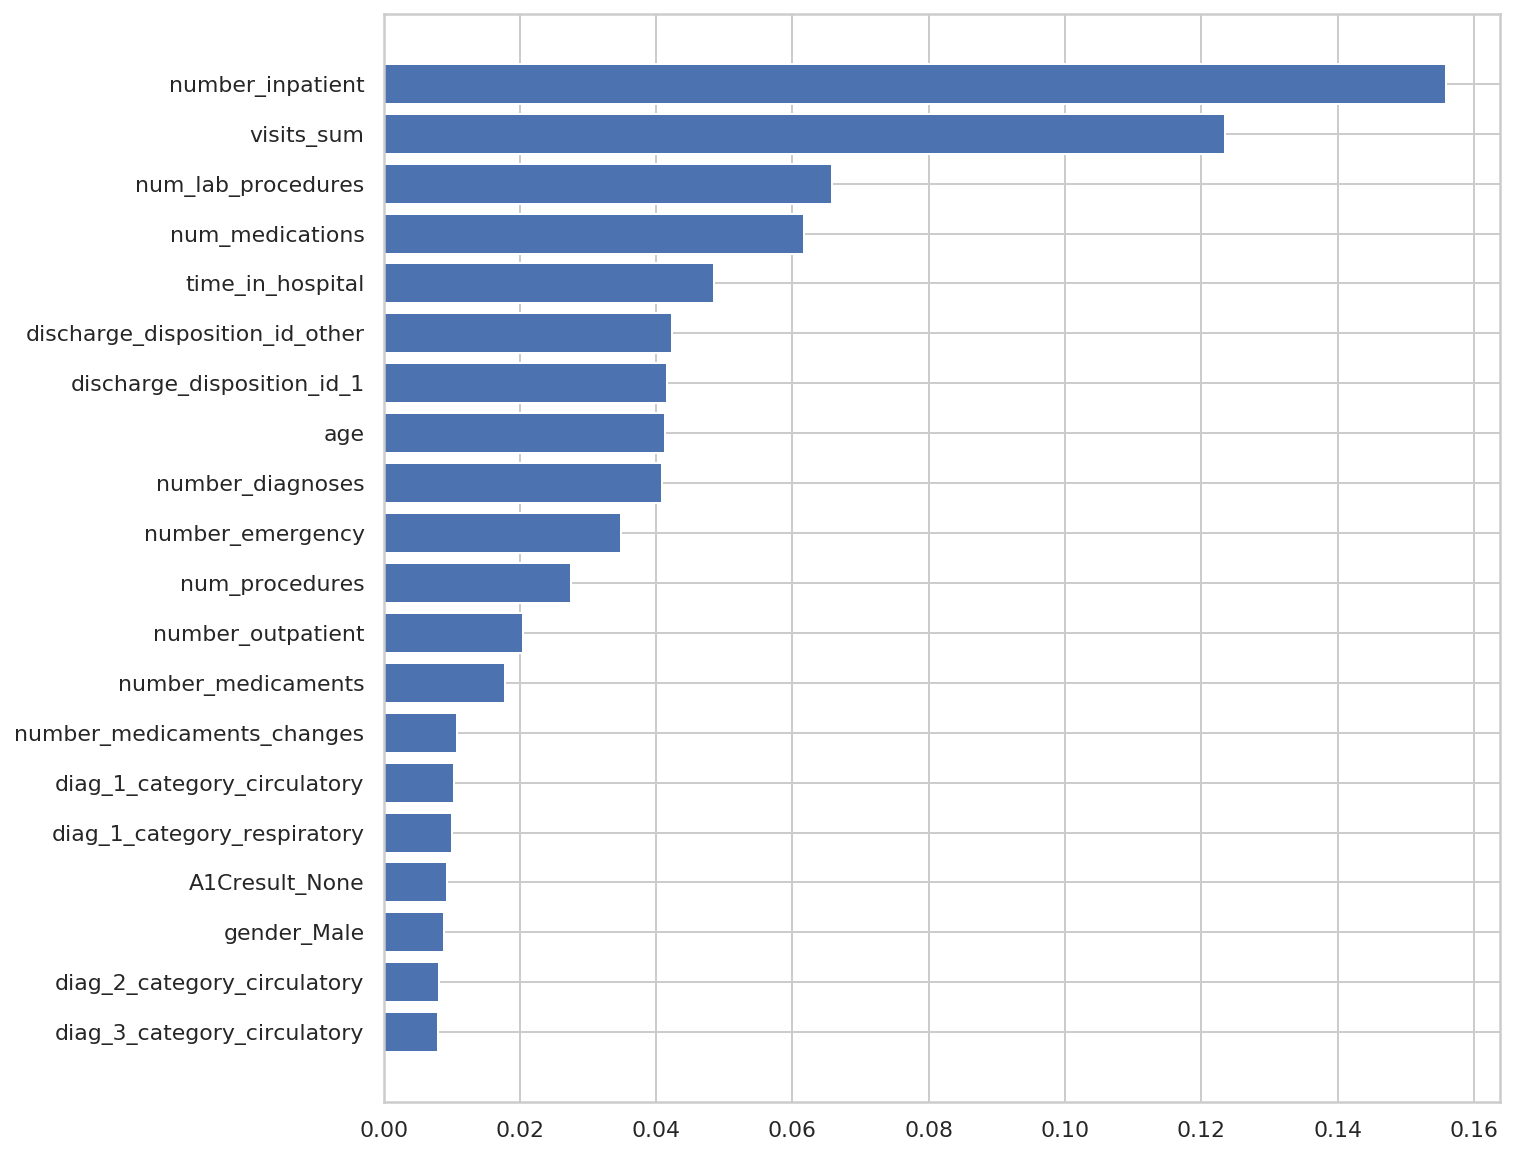

In [15]:
sorted_features = plot_feature_importance(rf.feature_importances_, X_train.columns, 20)

#### XGBoost

##### 1. Original data

              precision    recall  f1-score   support

           0       0.93      0.50      0.65     18090
           1       0.15      0.69      0.24      2263

    accuracy                           0.52     20353
   macro avg       0.54      0.59      0.45     20353
weighted avg       0.84      0.52      0.61     20353

ROC AUC score: 0.638


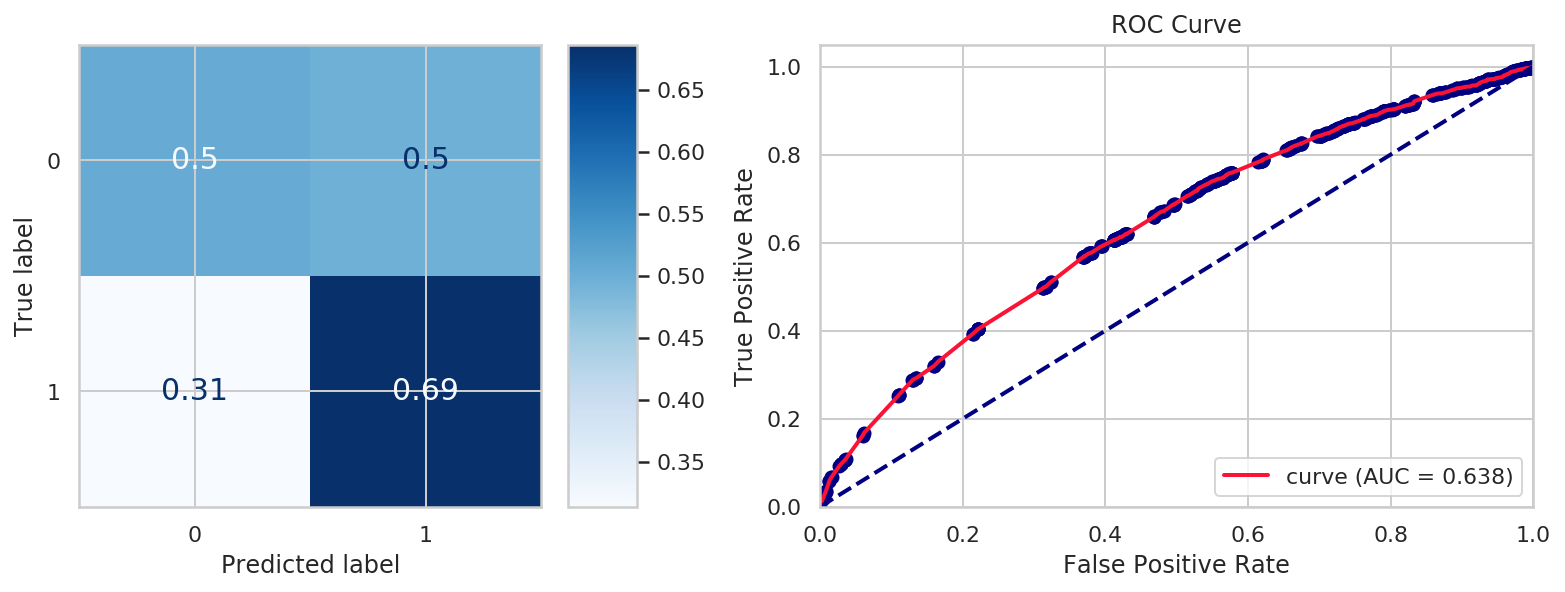

In [16]:
xg = xgb.XGBClassifier(
    random_state=42, learning_rate=0.001,
    max_depth=6, scale_pos_weight=9
)
xg.fit(X_train,y_train)
evaluate_model(xg, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.93      0.57      0.71     18090
           1       0.16      0.63      0.25      2263

    accuracy                           0.58     20353
   macro avg       0.54      0.60      0.48     20353
weighted avg       0.84      0.58      0.66     20353

ROC AUC score: 0.643


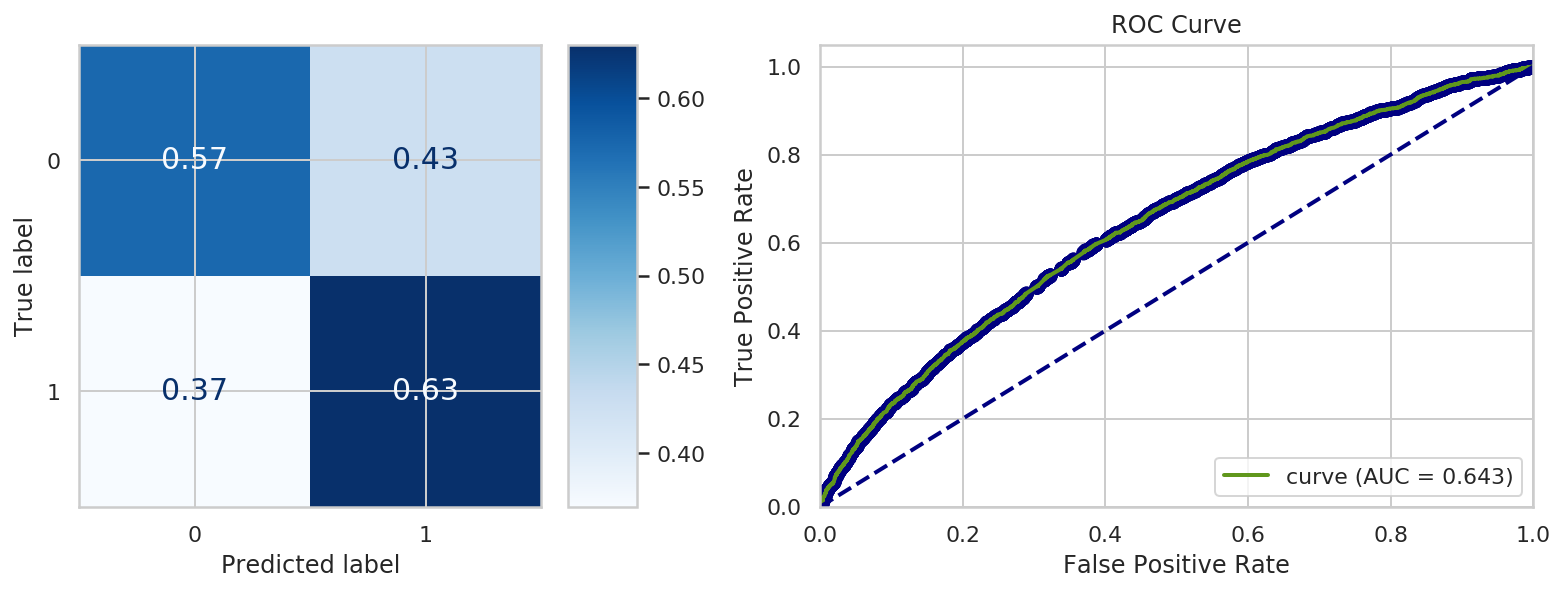

In [17]:
xg_u = xgb.XGBClassifier(random_state=42, learning_rate=0.01, max_depth=6)
xg_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(xg_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.91      0.39      0.54     18090
           1       0.12      0.69      0.21      2263

    accuracy                           0.42     20353
   macro avg       0.52      0.54      0.38     20353
weighted avg       0.82      0.42      0.51     20353

ROC AUC score: 0.567


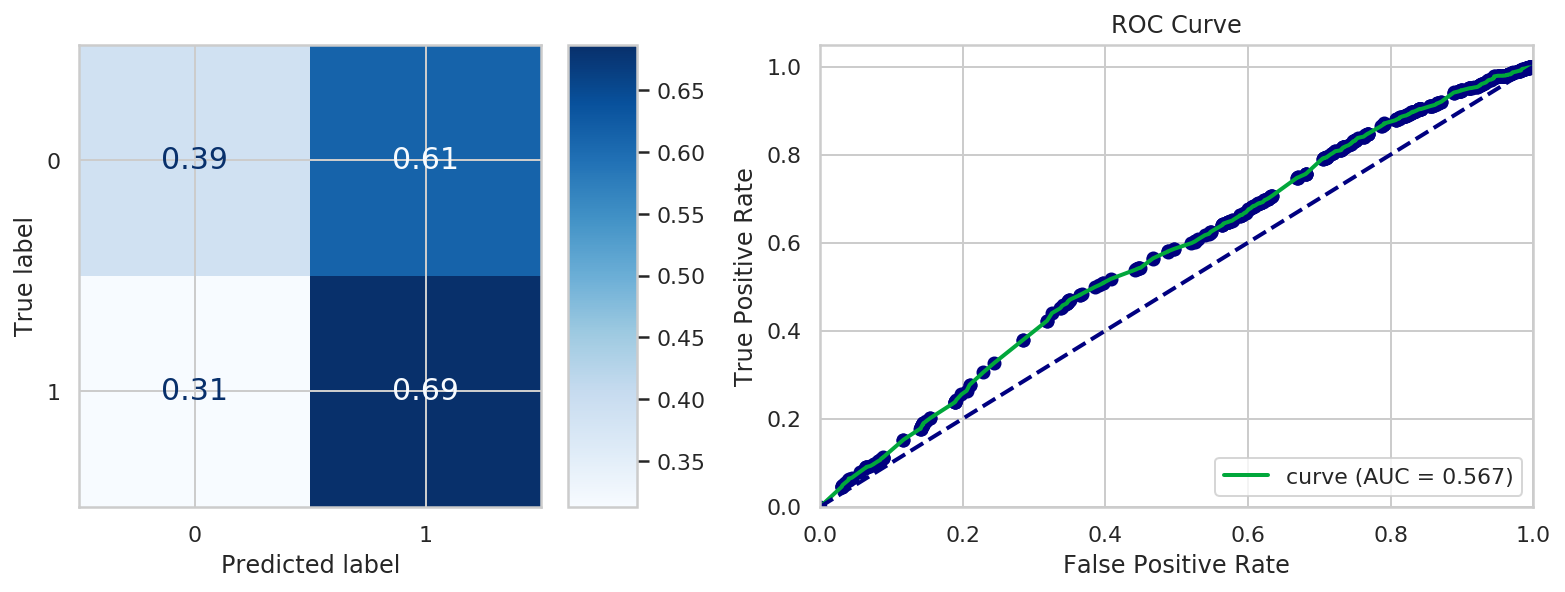

In [18]:
xg_o = xgb.XGBClassifier(random_state=42, learning_rate=0.001, scale_pos_weight=4)
xg_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(xg_o, X_test, y_test)

##### Results comparison

XGBoost models achieved slightly worse results than Random forests. The same patterns in data balancers are observed also here. Model trained on undersampled data achieved comparable (slightly better) results as model trained on original data. Again, model trained on oversampled data using SMOTE achieved worse results. But at the end, XGBoost is more sensitive on hyperparemeters besides Random forest, so there is space for improvements.

In [19]:
compare_models([xg, xg_u, xg_o], 
               ['XGBoost', 'XGBoost undersampled', 'XGBoost oversampled'], 
               X_test, y_test)

                         Accuracy   F1 (micro)  F1 (macro)  Precision   Recall    AUC ROC
XGBoost                |   0.52   |   0.52    |   0.45    |   0.15    |   0.69   |   0.64   |
XGBoost undersampled   |   0.58   |   0.58    |   0.48    |   0.16    |   0.63   |   0.64   |
XGBoost oversampled    |   0.42   |   0.42    |   0.38    |   0.12    |   0.69   |   0.57   |


##### Feature importances

Most important features are quite similar to those from Random forest. The main difference that can be seen on plot below is that XGBoost relies heavily on two features only (`number_impatients` and `discharge_disposition_id_1`). 

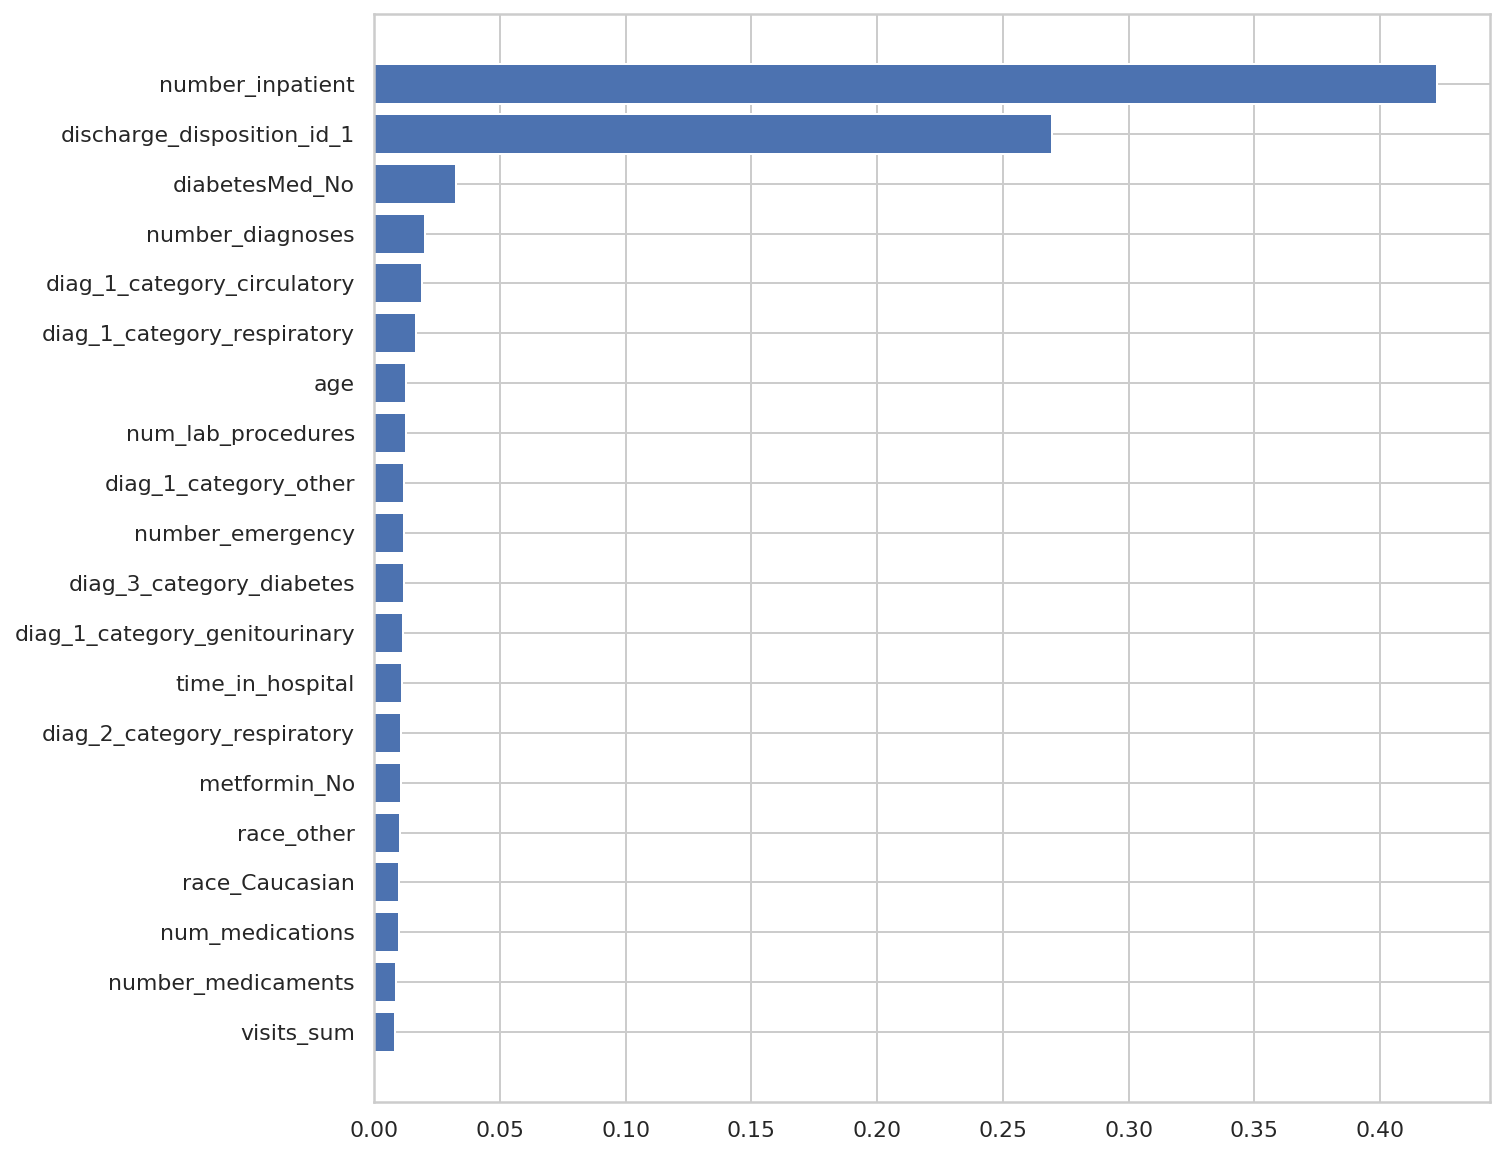

In [20]:
sorted_features = plot_feature_importance(xg.feature_importances_, X_train.columns, 20)

#### MLP (multilayer perceptron)

##### 1. Original data

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18090
           1       0.41      0.02      0.03      2263

    accuracy                           0.89     20353
   macro avg       0.65      0.51      0.49     20353
weighted avg       0.84      0.89      0.84     20353

ROC AUC score: 0.643


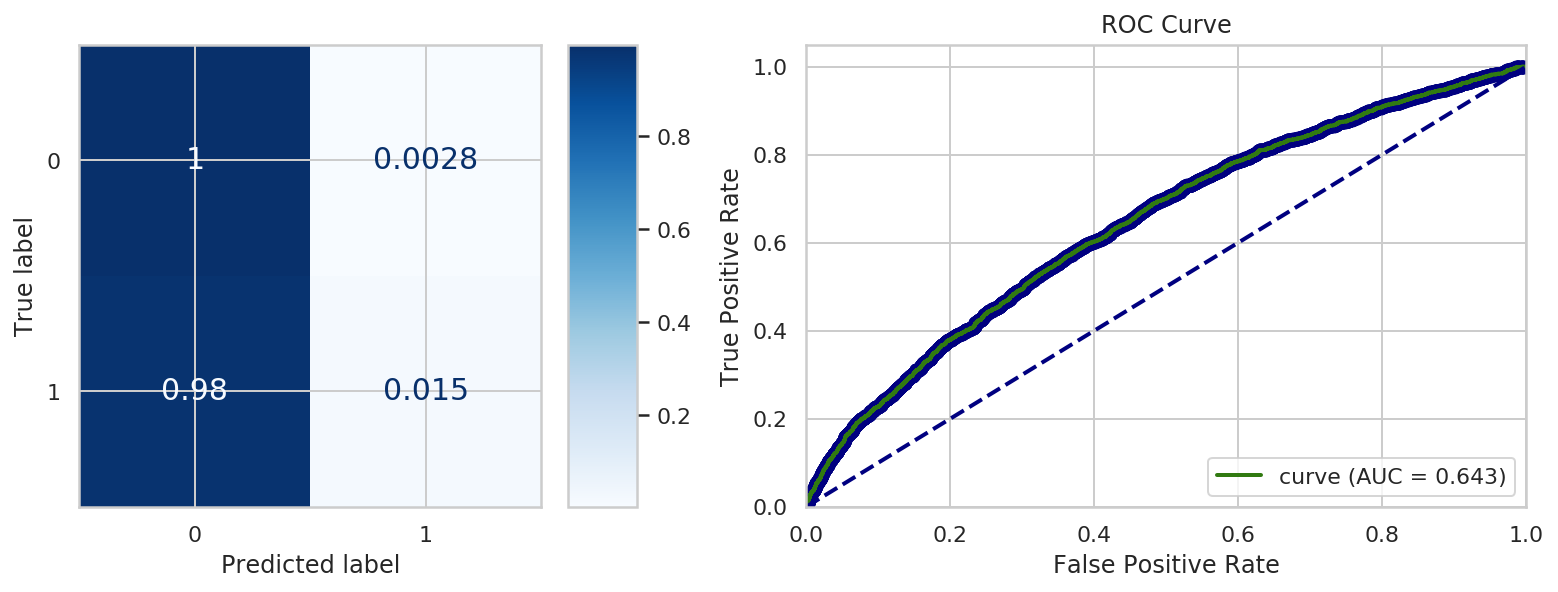

In [21]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64), max_iter=30,
    activation='relu', solver='adam',
    random_state=42
)
mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.92      0.64      0.75     18090
           1       0.16      0.56      0.25      2263

    accuracy                           0.63     20353
   macro avg       0.54      0.60      0.50     20353
weighted avg       0.84      0.63      0.70     20353

ROC AUC score: 0.64


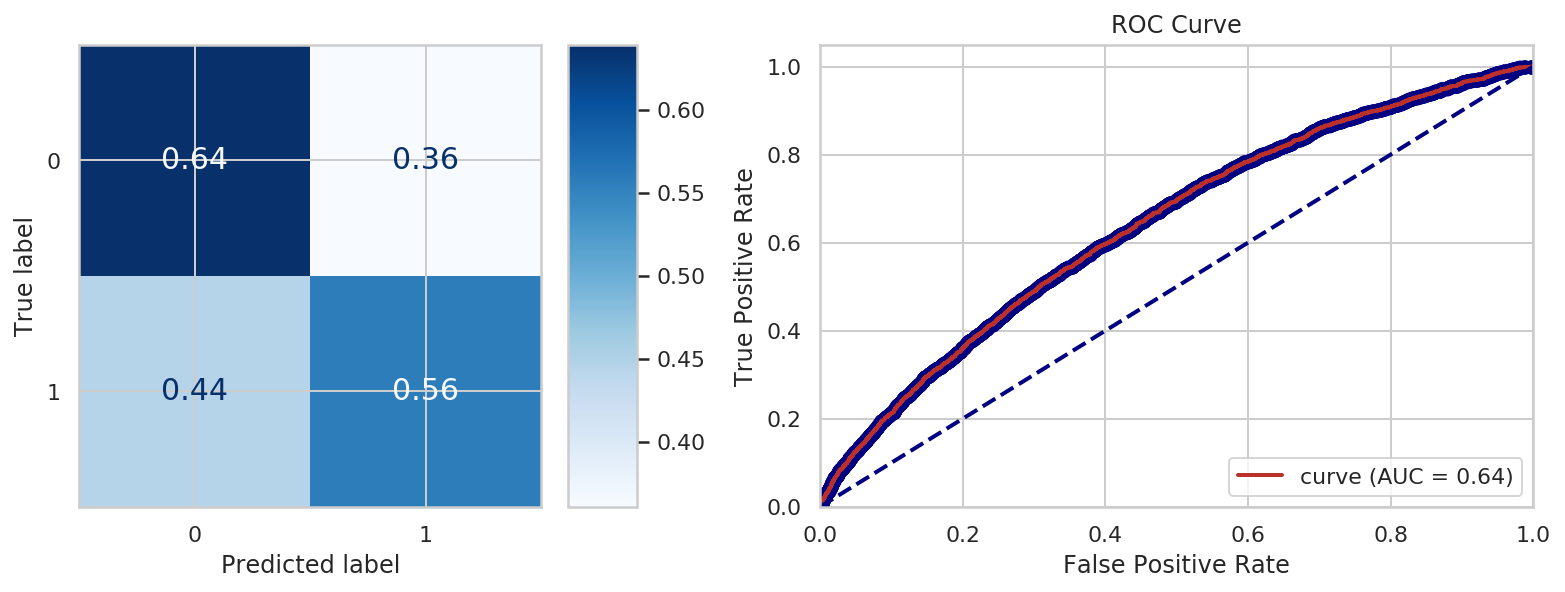

In [22]:
mlp_u = MLPClassifier(
    hidden_layer_sizes=(128,64), max_iter=20,
    activation='relu', solver='adam',
    random_state=42
)
mlp_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(mlp_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18090
           1       0.35      0.02      0.04      2263

    accuracy                           0.89     20353
   macro avg       0.62      0.51      0.49     20353
weighted avg       0.83      0.89      0.84     20353

ROC AUC score: 0.644


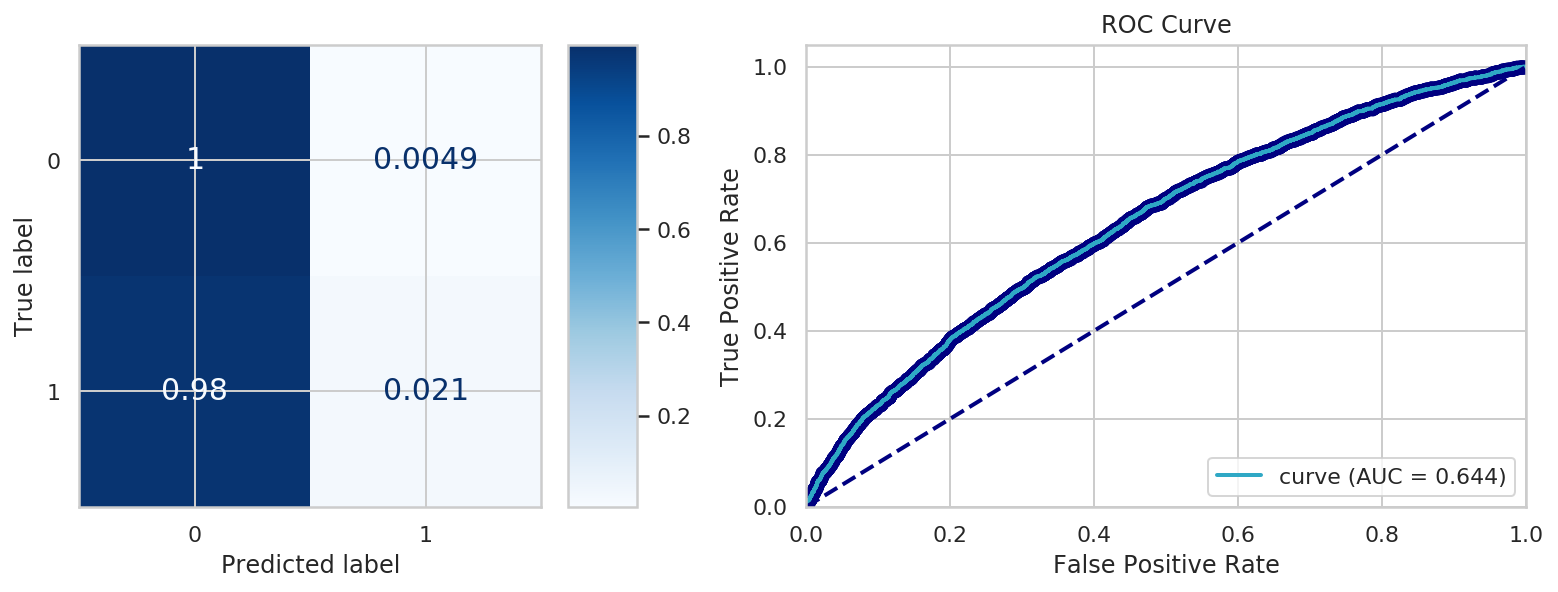

In [23]:
mlp_o = MLPClassifier(
    hidden_layer_sizes=(128,64), max_iter=20,
    activation='relu', solver='adam',
    random_state=42
)
mlp_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(mlp_o, X_test, y_test)

##### Results comparison

MLP models achieved results comparable with Random forests or XGBoost models. However, best results have been achieved on undersampled data, where recall and precision scores are comparable with those from Random forest models (even though precision is worse than in other two).

In [24]:
compare_models([mlp, mlp_u, mlp_o], 
               ['MLP', 'MLP undersampled', 'MLP oversampled'], 
               X_test, y_test)

                     Accuracy   F1 (micro)  F1 (macro)  Precision   Recall    AUC ROC
MLP                |   0.89   |   0.89    |   0.49    |   0.41    |   0.02   |   0.64   |
MLP undersampled   |   0.63   |   0.63    |   0.50    |   0.16    |   0.56   |   0.64   |
MLP oversampled    |   0.89   |   0.89    |   0.49    |   0.35    |   0.02   |   0.64   |


### Ensemble methods

All from previously trained models have achieved comparable results. In this section, various ensemble models will be tried to overcome previously achieved results.

In all of the following methods, **algorithms are trained on undersampled data** as this setup seems to be the best (according to previous results).

#### Bagging

*A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.*

Source: [Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

              precision    recall  f1-score   support

           0       0.93      0.59      0.73     18090
           1       0.16      0.64      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.55      0.62      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.652


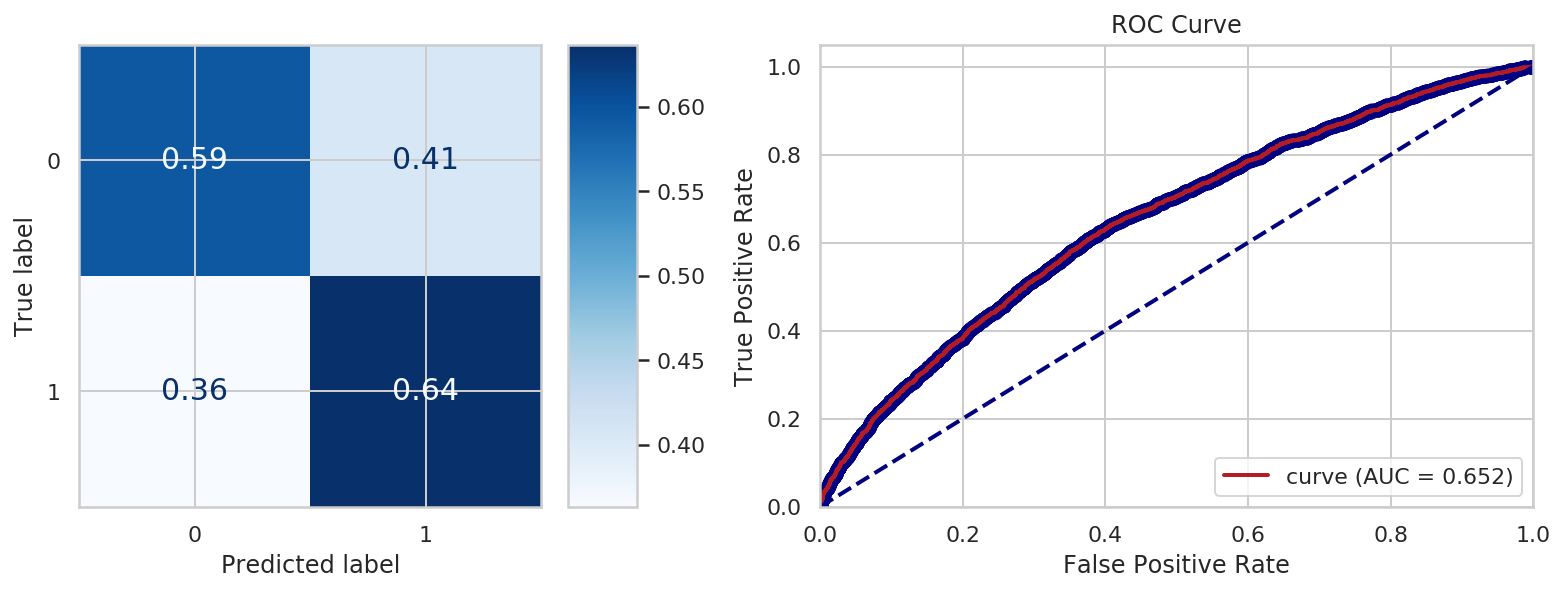

In [25]:
clf_bagging = BaggingClassifier(RandomForestClassifier(max_depth=10, random_state=42))
clf_bagging.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(clf_bagging, X_test, y_test)

#### Voting

*The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.*

Source: [Scikit-learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

              precision    recall  f1-score   support

           0       0.92      0.62      0.74     18090
           1       0.16      0.60      0.26      2263

    accuracy                           0.62     20353
   macro avg       0.54      0.61      0.50     20353
weighted avg       0.84      0.62      0.69     20353

ROC AUC score: 0.651


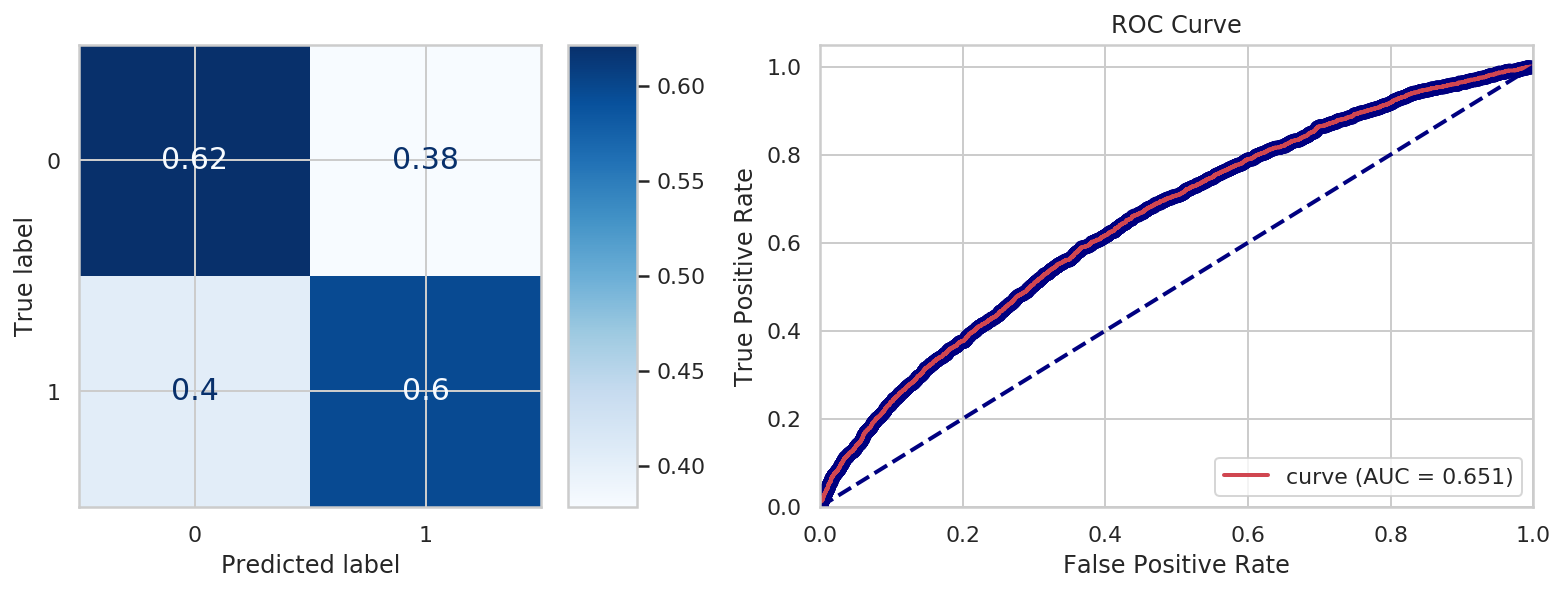

In [26]:
clf_voting = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth=10, random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42, learning_rate=0.01, max_depth=6)),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(128, 64), max_iter=20, activation='relu', solver='adam', random_state=42
        ))
    ],
    voting='soft'
)

clf_voting.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(clf_voting, X_test, y_test)

#### Stacking

*Stacked generalization is a method for combining estimators to reduce their biases. More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation.*

Source: [Scikit-learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)

              precision    recall  f1-score   support

           0       0.93      0.62      0.74     18090
           1       0.17      0.61      0.26      2263

    accuracy                           0.62     20353
   macro avg       0.55      0.61      0.50     20353
weighted avg       0.84      0.62      0.69     20353

ROC AUC score: 0.652


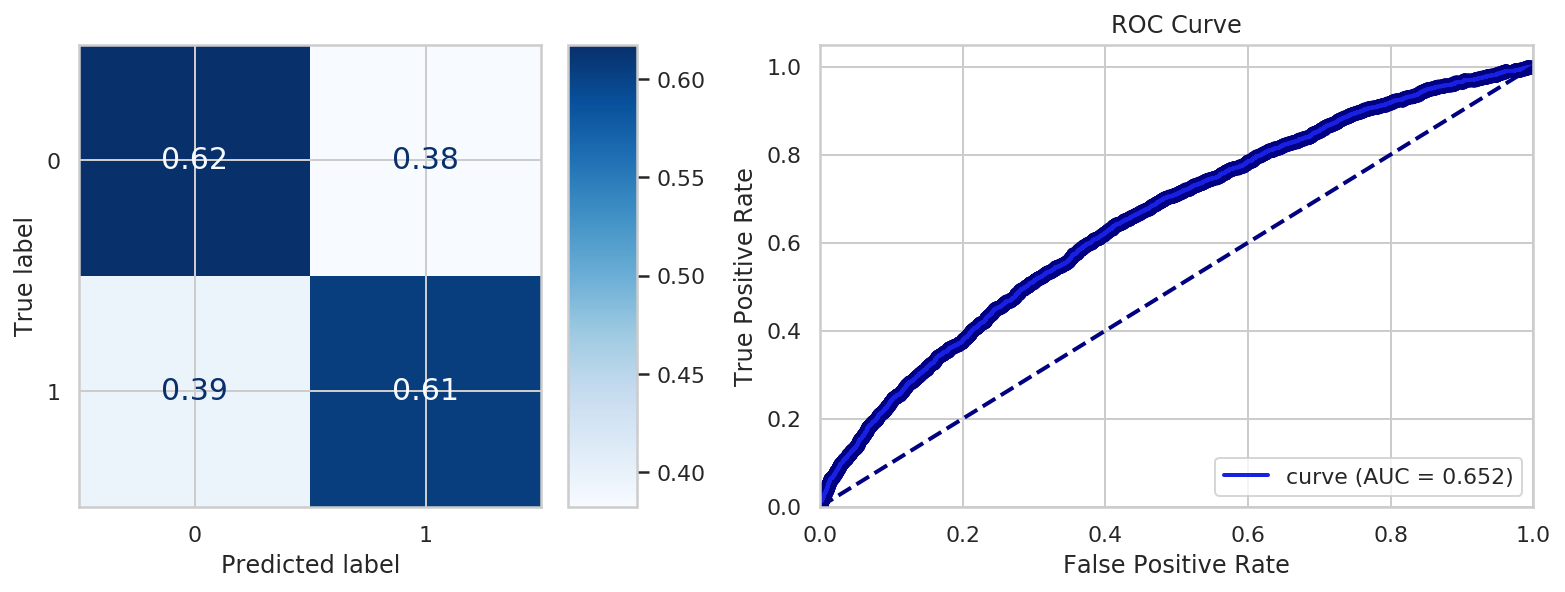

In [27]:
clf_stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth=10, random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42, learning_rate=0.01, max_depth=6)),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(128, 64), max_iter=20, activation='relu', solver='adam', random_state=42
        ))
    ],
    final_estimator=LogisticRegression()
)
clf_stacking.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(clf_stacking, X_test, y_test)

#### Results comparison

Because none of the ensemble methods significantly improved the prediction performance, no more experiments and tuning will be performed this way.

### Final comparison of models

Final comparison of all models is shown in the table below. The best AUC ROC score achieved Random forest trained on original and also on undersampled data, alongside with all ensemble methods trained on undersampled data. Also, comparable results have been achieved with various setups of XGBoost and MLP.

We can say that oversampling using SMOTE method did not help even decreased the classification performance.

For final evaluation phase, Random forest will be chosen because of achieved results, the speed and the simplicity (in comparison with other algorithms). Even though ensemble methods achieved almost the same results, Random forest is preferred because of it's simplicity against ensemble methods.

In [28]:
compare_models(
    [rf, rf_u, rf_o, xg, xg_u, xg_o, mlp, mlp_u, mlp_o, clf_bagging, clf_voting, clf_stacking], 
    ['RF', 'RF undersampled', 'RF oversampled',
     'XGBoost', 'XGBoost undersampled', 'XGBoost oversampled',
     'MLP', 'MLP undersampled', 'MLP oversampled',
     'Bagging undersampled', 'Voting undersampled',
     'Stacking undersampled'
    ], 
   X_test, y_test)

                          Accuracy   F1 (micro)  F1 (macro)  Precision   Recall    AUC ROC
RF                      |   0.67   |   0.67    |   0.52    |   0.17    |   0.53   |   0.65   |
RF undersampled         |   0.60   |   0.60    |   0.49    |   0.16    |   0.63   |   0.65   |
RF oversampled          |   0.42   |   0.42    |   0.38    |   0.13    |   0.75   |   0.60   |
XGBoost                 |   0.52   |   0.52    |   0.45    |   0.15    |   0.69   |   0.64   |
XGBoost undersampled    |   0.58   |   0.58    |   0.48    |   0.16    |   0.63   |   0.64   |
XGBoost oversampled     |   0.42   |   0.42    |   0.38    |   0.12    |   0.69   |   0.57   |
MLP                     |   0.89   |   0.89    |   0.49    |   0.41    |   0.02   |   0.64   |
MLP undersampled        |   0.63   |   0.63    |   0.50    |   0.16    |   0.56   |   0.64   |
MLP oversampled         |   0.89   |   0.89    |   0.49    |   0.35    |   0.02   |   0.64   |
Bagging undersampled    |   0.60   |   0.60    |   0.4